## Perspective in Computation Analysis
### Assignment 4: Simulating your income

#### Name: Xiang Zhang
#### snzhang@uchicago.edu

### Problem One
We first import all packages that'll be used in this assignment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.mlab as mlab
from scipy import stats
import pylab 
import random

Then I write down the function for doing the simulation. The input of the function is a dictionary containing all parameters needed, and it returns a matrix containing all income paths (10000 simulation for 40 years). In the function, I first drawing 10,000 sets of 40 normally distributed errors with mean 0 and standard deviation equaling to 0.1. Then follow the income process defined in the assignment instruction, I simulate income process 10,000 times.

In [3]:
def simulate_income(simu_profile):
	"""
	A function to simulate income

	Inputs:
		simu_profile: a dictionary documenting the simultion
		settings (simulation parameters)
		simu_profile = {
        'inc'         : starting income
        'gr'          : growth rate
        'persist'	  : persistance
        'sigma'       : standard deviation of income process 
        'num_draws'   : number of simulations
    }

    Return:
    inc_mat: (A numpy array) storing all simulation income path
	"""

	# Set random seed
	np.random.seed(93822)

	log_errors = np.random.normal(loc = 0.0, scale = simu_profile["sigma"], 
								  size = (40, simu_profile["num_draws"]))

	#create a matrix of dim (40, num_draws)
	ln_inc_mat = np.zeros((40, simu_profile["num_draws"]))

    #Initial condition
	ln_inc_mat[0, :] = np.log(simu_profile["inc"]) + log_errors[0, :]

	for yr in range(1, 40):
		ln_inc_mat[yr, :] = (1 - simu_profile["persist"]) * \
                            (np.log(simu_profile["inc"]) + simu_profile["gr"] * yr) + \
							simu_profile["persist"] * ln_inc_mat[yr - 1, :] + \
							log_errors[yr, :]

	inc_mat = np.exp(ln_inc_mat)

	return inc_mat

Below I do simulation. First, I set the simulation parameters. Secondly, I call the "simulate_income" function to do simulation. Then I plot the income path of a randomly chosen individual.

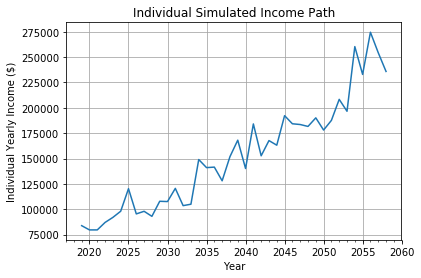

In [21]:
simu_profile = {
	'inc': 80000,
	'gr': 0.03,
	'persist': 0.2,
	'sigma': 0.1,
	'num_draws': 10000,
	'st_year': 2019,
	'simu_year': 40
	}

inc_mat = simulate_income(simu_profile)

%matplotlib inline
year_vec = np.arange(simu_profile['st_year'], simu_profile['st_year'] + simu_profile['simu_year'])
individual = random.randint(0, 10000)
fig, ax = plt.subplots()
plt.plot(year_vec, inc_mat[:, individual])
minorLocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.grid(b = True, which = 'major', color='0.65', linestyle='-')
plt.title('Individual Simulated Income Path', fontsize = 12)
plt.xlabel(r'Year')
plt.ylabel(r'Individual Yearly Income (\$)')

### Problem Two

Below I plot a histogram with 50 bins of year t = 2019 initial income for each of the 10,000 simulations

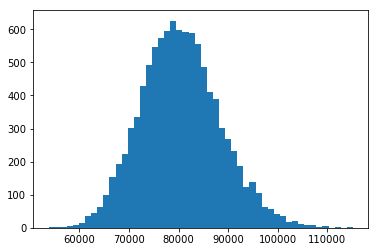

In [22]:
plt.hist(inc_mat[0, :], bins = 50) 

plt.show()

From the histogram, we cannot see clearly whether the income distribution is normal distribution (seems to be a little bit skewed). To test whether it's normal distributed or not, I draw a Q-Q plot below. 

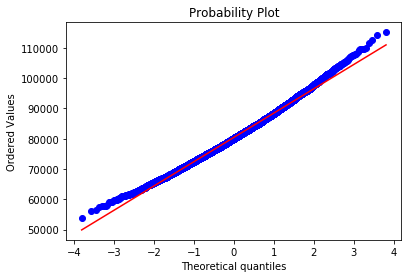

In [23]:
stats.probplot(inc_mat[0, :], dist="norm", plot=pylab)
pylab.show()

From the Q-Q plot, we can see clearly that the distribution is skewed on two tails, which suggests that it's not normal distribution. To test the distribution ststistically, I use python's scipy package to test whether the dsitribution is a normal distribution or it's a log-normal distribution.

In [24]:
stats.mstats.normaltest(inc_mat[0, :])

NormaltestResult(statistic=143.84372217278354, pvalue=5.8174492321985253e-32)

In [25]:
stats.lognorm.fit(inc_mat[0, :])

(7.5351300577657554, 53767.569187313537, 1.6898089119477078)

From the test, we know that the distribution of income **is not normal**. But can be regarded as a log-normal distribution.

After getting the distribution, I compute the percentage of classmates earning more than 100,000 dollars in the first year, and the percentage of classmates earning less than 70,000 dollars.

In [26]:
percent_gt_100000 = (inc_mat[0, :] > 100000).sum() / 10000
percent_lt_70000 = (inc_mat[0, :] < 70000).sum() / 10000
print("Share of students earn more than $100000: ", percent_gt_100000 * 100, "%") 
print("Share of students earn less than $70000: ", percent_lt_70000 * 100, "%")

Share of students earn more than $100000:  1.33 %
Share of students earn less than $70000:  9.06 %


Based on my computation, 1.33% students earn more than 100000 dollars per year, and 9.06% students ear leass than 70000 dollars

### Problem 3

In this problem, I will compute the years needed to payoff the loan. To do so, I first define a function "debt_payment" to compute the years needed to payoff loans for all 10000 simulations. The input of the function is a numpy array storing the income paths, the amount of the debt and the percentage of income used to pay the loan each year. The function return a numpy array indicating the years needed to payoff the loan for each simulation.

In [27]:
def debt_payment(inc_mat, debt_amount, payment_rate):
	"""
	A function determing how many years to pay all debt

	Inputs:
	- inc_mat: A matrix representing all inocme paths
	- debt_amount: (int) indicating how many debt one have to pay
	- payment_rate: (float) indicating what percentage of income will be used 
							to pay the debt

	Return: a list of how many years to pay all debt for all simulations
	"""

	payoff_year = []

	for i in range(0, 10000):
		path = inc_mat[:, i]
		amount = 0

		for yr in range(0, 40):
			amount += path[yr] * payment_rate

			if amount >= debt_amount:
				payoff_year.append(yr + 1)
				break

	return np.array(payoff_year)

Below, I do the simulation and tabulate the possible years to payoff loans and there frequency.

In [28]:
payoff_year = debt_payment(inc_mat, 95000, 0.1)
value, counts = np.unique(payoff_year, return_counts=True)
print("In my simulation, the possible years to payoff loan are:", value)
print("In my simulation, the frequency for each possible year are:", counts, "respectively")

In my simulation, the possible years to payoff loan are: [10 11 12]
In my simulation, the frequency for each possible year are: [1813 7988  199] respectively


The I define a function to plot the histogram of the "payoff years"

In [29]:
def plot_payoff_year(payoff_year):
	plt.hist(payoff_year,color="orange", bins = np.arange(min(payoff_year), max(payoff_year) + 2, 1.0))
	plt.xticks(np.arange(min(payoff_year), max(payoff_year)+2, 1.0))
	plt.ylabel("Count")
	plt.xlabel("Time (years)")
	plt.title("Histogram of Time of Years to Payoff Loan")
	plt.show()

The distribution of the payoff years is shown below:

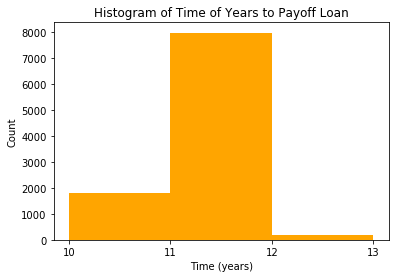

In [30]:
plot_payoff_year(payoff_year)

And the percentage of students who are able to payoff loans in less than or equal to 10 years are:

In [31]:
percent_payoff_ly10 = (payoff_year <= 10).sum() / 10000

print("Percent of students payoff loans in less than or equal to 10 years", percent_payoff_ly10 * 10, "%")

Percent of students payoff loans in less than or equal to 10 years 1.813 %


### Problem 4

In this problem, the initial income "inc_0" is changed to 85000, and the standard deviation of income process is changed to 0.15. Thus, I first update the "simu_profile".

In [32]:
simu_profile = {
	'inc': 85000,
	'gr': 0.03,
	'persist': 0.2,
	'sigma': 0.15,
	'num_draws': 10000,
	'st_year': 2019,
	'simu_year': 40
	}

Then do the simulation of income process, and tabulate the possible years to payoff loans and there frequency.

In [33]:
inc_mat = simulate_income(simu_profile)
payoff_year = debt_payment(inc_mat, 95000, 0.1)
value, counts = np.unique(payoff_year, return_counts=True)
print("In my simulation, the possible years to payoff loan are:", value)
print("In my simulation, the frequency for each possible year are:", counts, "respectively")

In my simulation, the possible years to payoff loan are: [ 8  9 10 11 12]
In my simulation, the frequency for each possible year are: [   3  668 6321 2952   56] respectively


Then I plot the histogram.

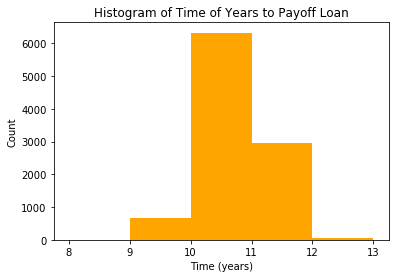

In [34]:
plot_payoff_year(payoff_year)

Finally, I compute the percentage of calssmates who are able to payoff the loans in less than or equal to 10 years.

In [35]:
percent_payoff_ly10 = (payoff_year <= 10).sum() / 10000

print("Percent of students payoff loans in less than or equal to 10 years", percent_payoff_ly10 * 100, "%")

Percent of students payoff loans in less than or equal to 10 years 69.92 %


All four problems are solved! Thanks for your attention!